In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
import datetime

%matplotlib inline

In [4]:
df = pd.read_csv('../input/data.csv', encoding = 'ISO-8859-1')
df.head(2)

# Data Cleaning 
#### Check missing values for each column 

In [7]:
# check missing values for each column 
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

In [8]:
# change the invoice_date format - String to Timestamp format
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

In [9]:
# change description - UPPER case to LOWER case
df['Description'] = df.Description.str.lower()

#### Remove rows with missing values

In [11]:
# df_new without missing values
df_new = df.dropna()

In [12]:
# check missing values for each column 
df_new.isnull().sum().sort_values(ascending=False)

Country        0
CustomerID     0
UnitPrice      0
InvoiceDate    0
Quantity       0
Description    0
StockCode      0
InvoiceNo      0
dtype: int64

In [13]:
# change columns tyoe - String to Int type 
df_new['CustomerID'] = df_new['CustomerID'].astype('int64')

In [14]:
df_new.describe().round(2)

,Quantity,UnitPrice,CustomerID
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


#### Remove Quantity with negative values

In [16]:
df_new = df_new[df_new.Quantity > 0]

#### Add the column - amount_spent

In [18]:
df_new['amount_spent'] = df_new['Quantity'] * df_new['UnitPrice']

#### Add the columns - Month, Day and Hour for the invoice

In [19]:
df_new.insert(loc=2, column='year_month', value=df_new['InvoiceDate'].map(lambda x: 100*x.year + x.month))
df_new.insert(loc=3, column='month', value=df_new.InvoiceDate.dt.month)
df_new.insert(loc=4, column='day', value=(df_new.InvoiceDate.dt.dayofweek)+1)
df_new.insert(loc=5, column='hour', value=df_new.InvoiceDate.dt.hour)

In [20]:
df_new.head(2)

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent
0,536365,85123A,201012,12,3,8,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,201012,12,3,8,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


# Exploratory Data Analysis (EDA)

## How many orders made by the customers?

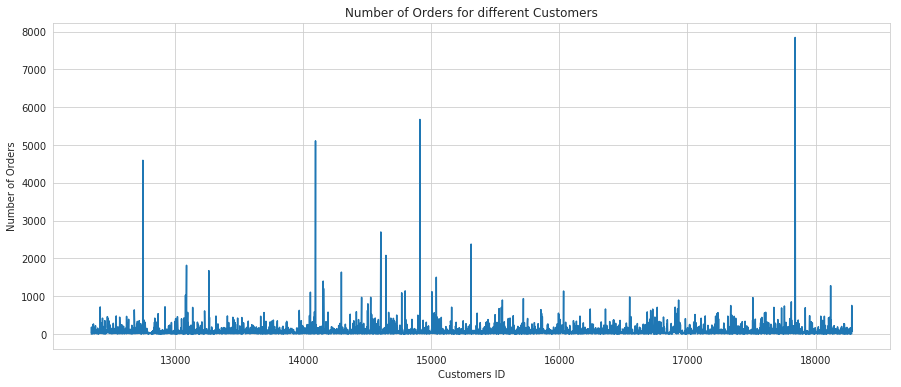

In [24]:
orders = df_new.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.CustomerID, orders.InvoiceNo)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

### Check TOP 5 most number of orders

In [25]:
print('The TOP 5 customers with most number of orders')
orders.sort_values(by='InvoiceNo', ascending=False).head()

The TOP 5 customers with most number of orders


,CustomerID,Country,InvoiceNo
4019,17841,United Kingdom,7847
1888,14911,EIRE,5677
1298,14096,United Kingdom,5111
334,12748,United Kingdom,4596
1670,14606,United Kingdom,2700


## How much money spent by the customers?

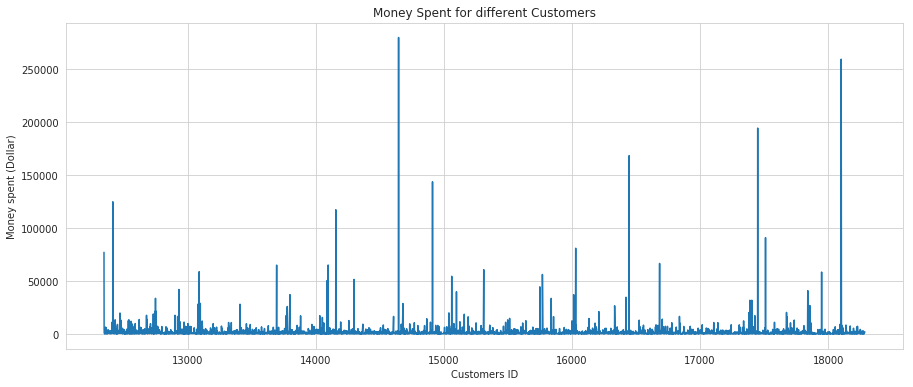

In [26]:
money_spent = df_new.groupby(by=['CustomerID','Country'], as_index=False)['amount_spent'].sum()

plt.subplots(figsize=(15,6))
plt.plot(money_spent.CustomerID, money_spent.amount_spent)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent for different Customers')
plt.show()

### Check TOP 5 highest money spent

In [27]:
print('The TOP 5 customers with highest money spent')
money_spent.sort_values(by='amount_spent', ascending=False).head()

The TOP 5 customers with highest money spent...


,CustomerID,Country,amount_spent
1698,14646,Netherlands,280206.02
4210,18102,United Kingdom,259657.30
3737,17450,United Kingdom,194550.79
3017,16446,United Kingdom,168472.50
1888,14911,EIRE,143825.06


# Number of Orders


## How many orders per month?

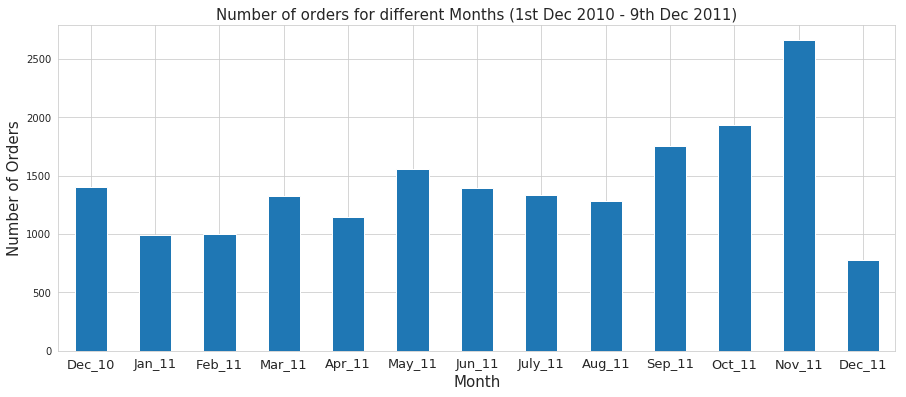

In [28]:
ax = df_new.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot('bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

## How many orders per day?

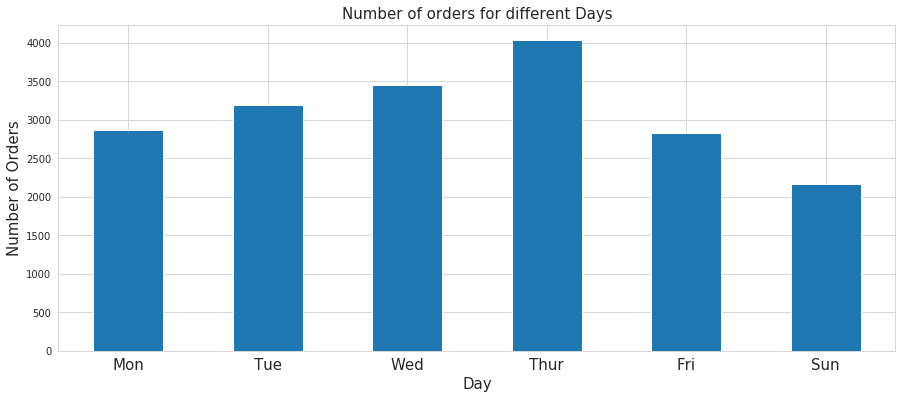

In [30]:
ax = df_new.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot('bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

 ## How many orders per hour?


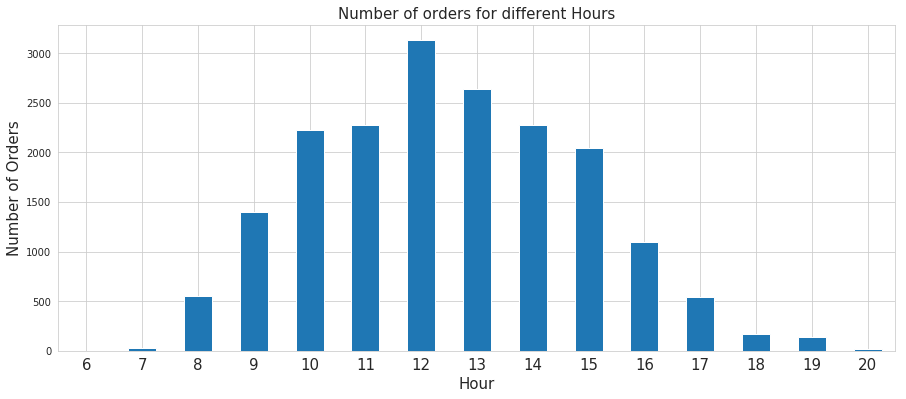

In [31]:
ax = df_new.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index().plot('bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

## Unit Price

In [33]:
df_new.UnitPrice.describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

**We see that there are unit price = 0 (FREE items)**

There are some free items given to customers from time to time.

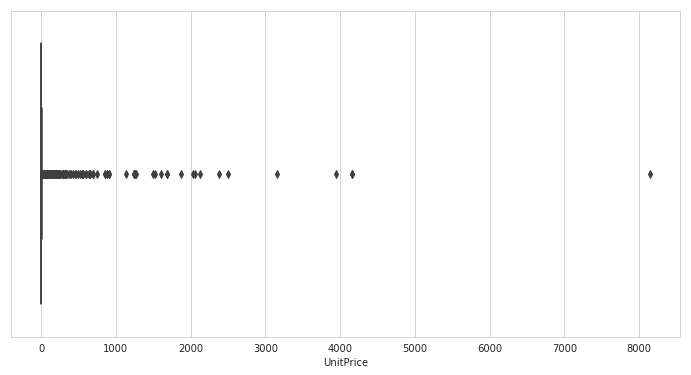

In [35]:
# check the distribution of unit price
plt.subplots(figsize=(12,6))
sns.boxplot(df_new.UnitPrice)
plt.show()

In [37]:
df_free = df_new[df_new.UnitPrice == 0]

In [38]:
df_free.head(5)

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent
9302,537197,22841,201012,12,7,14,round cake tin vintage green,1,2010-12-05 14:02:00,0.0,12647,Germany,0.0
33576,539263,22580,201012,12,4,14,advent calendar gingham sack,4,2010-12-16 14:36:00,0.0,16560,United Kingdom,0.0
40089,539722,22423,201012,12,2,13,regency cakestand 3 tier,10,2010-12-21 13:45:00,0.0,14911,EIRE,0.0
47068,540372,22090,201101,1,4,16,paper bunting retrospot,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0.0
47070,540372,22553,201101,1,4,16,plasters in tin skulls,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0.0


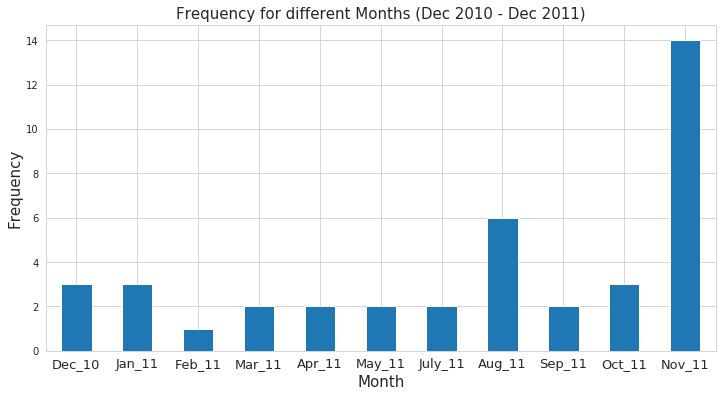

In [40]:
ax = df_free.year_month.value_counts().sort_index().plot('bar',figsize=(12,6), color=color[0])
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.show()


- On average, the company gave out 2-4 times FREE items to customers each month (Except in June 2011)

# Country

## How many orders for each country?

In [46]:
temp = df_new[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

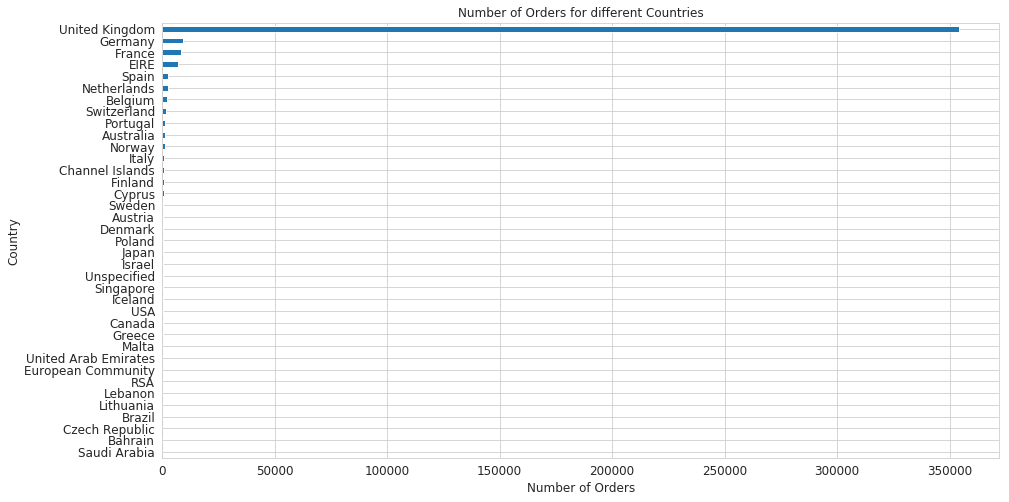

In [47]:
group_country_orders = df_new.groupby('Country')['InvoiceNo'].count().sort_values()
# del group_country_orders['United Kingdom']

# plot number of unique customers in each country (with UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot('barh', fontsize=12, color=color[0])
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

## How much money spent by each country?

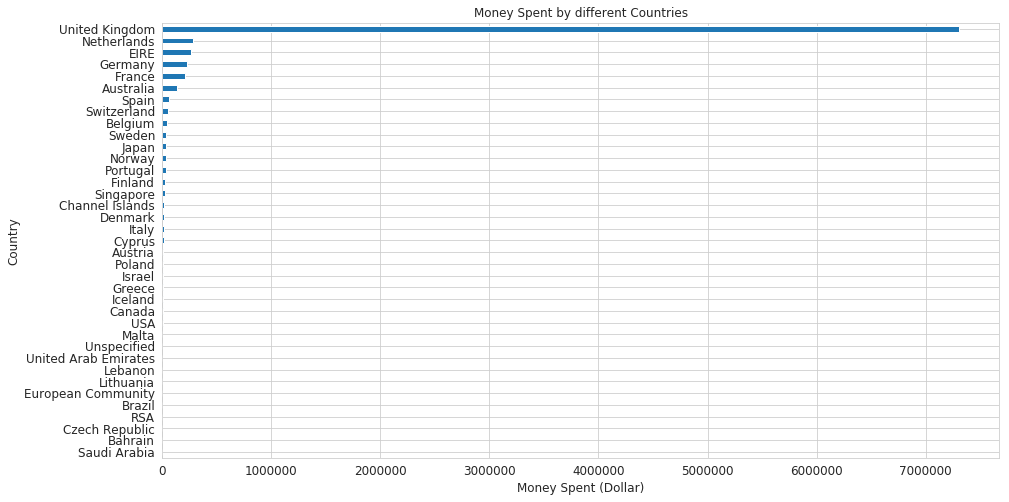

In [48]:
group_country_amount_spent = df_new.groupby('Country')['amount_spent'].sum().sort_values()
# del group_country_orders['United Kingdom']

# plot total money spent by each country (with UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot('barh', fontsize=12, color=color[0])
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()

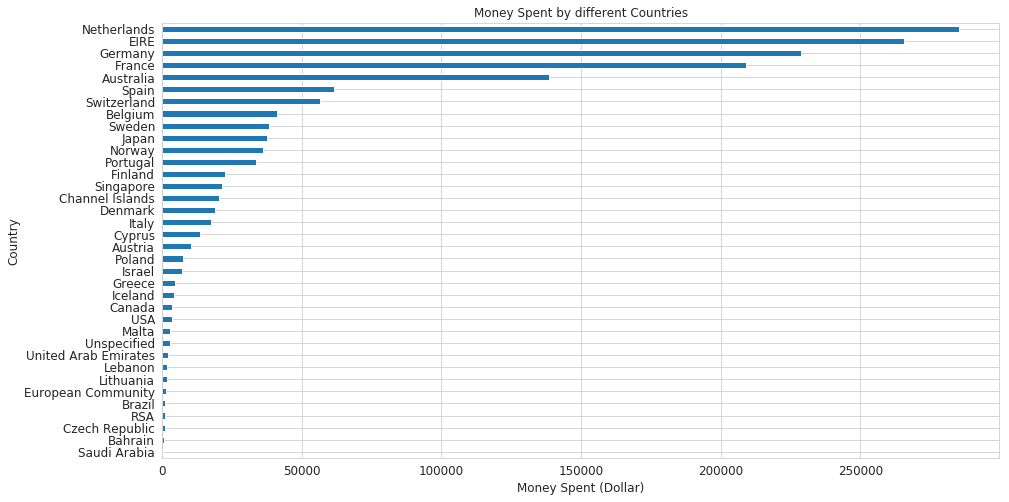

In [49]:
group_country_amount_spent = df_new.groupby('Country')['amount_spent'].sum().sort_values()
del group_country_amount_spent['United Kingdom']

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot('barh', fontsize=12, color=color[0])
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries', fontsize=12)
plt.show()